In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost
from gplearn.genetic import SymbolicRegressor

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from preprocess import *
from models import RobustPCANN

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

from pytorch_robust_pca import *

# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder

# Tracking
from tqdm import trange

import sympy
import sympytorch

Running Python 3.9.6
You can use npar for np.array


In [2]:
# Loading the KS sol
DATA_PATH = "../deephpms_data/KS_simple3.pkl"

data = pickle_load(DATA_PATH)

t = data['t']
x = data['x']

X, T = np.meshgrid(x, t)
Exact = data['u'].T

x_star = X.flatten()[:,None]
t_star = T.flatten()[:,None]

X_star = np.hstack((x_star, t_star))

Loaded from ../deephpms_data/KS_simple3.pkl


In [3]:
# Adding noise
noise_intensity = 1
X_star_clean = X_star
noise = perturb(X_star, intensity=noise_intensity, noise_type="normal", overwrite=False)
X_star = X_star + noise
print("Perturbed u_star with intensity =", float(noise_intensity))

Perturbed u_star with intensity = 1.0


In [4]:
print("Running Robust PCA on u_star")
rpca = R_pca_numpy(X_star)
X_star_L, X_star_S = rpca.fit(tol=1e-16, max_iter=10000, iter_print=100, verbose=False)
print('Robust PCA Loss:', mean_squared_error(X_star, X_star_L+X_star_S))
print('MSE to the generated noise:', mse_function(noise, X_star_S))

Running Robust PCA on u_star
Robust PCA Loss: 8.533963045023427e-21
MSE to the generated noise: 38.064284220131256


In [5]:
x_out, _, x_PSD = fft1d_denoise_numpy(X_star[:, 0:1], thres=None, c=0)
t_out, _, t_PSD = fft1d_denoise_numpy(X_star[:, 1:2], thres=None, c=0)
X_star_denoised = np.hstack((x_out, t_out))

In [6]:
mse_function(noise, (X_star-X_star_denoised))

9.546119662933805

In [7]:
print("What if we know only the noise dist? Is that help?")
mse_function(noise, np.random.rand(noise.shape[0], noise.shape[1]))

What if we know only the noise dist? Is that help?


29.220310856836978

In [8]:
import seaborn as sns

1


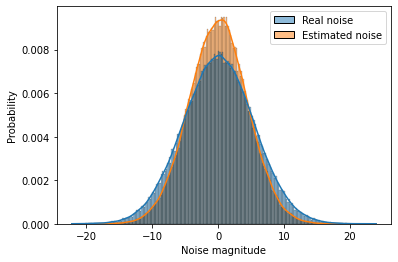

In [9]:
print(noise_intensity)
tmp = {"Real noise":noise.flatten(), "Estimated noise":(X_star-X_star_denoised).flatten()}
sns.histplot(tmp, kde=True, stat="probability")
plt.xlabel("Noise magnitude")
plt.show()

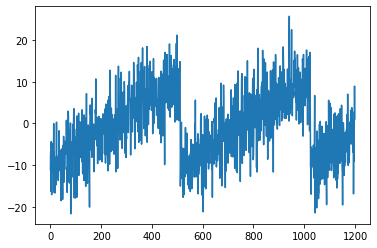

In [10]:
# The first 1200 points of the x signal (sampled from a uniform dist)
plt.plot(X_star[:, 0:1].flatten()[:1200])
plt.show()

In [ ]:
n_exps = 50
all_fftc0_noises = np.zeros((u_star_S.shape[0], n_exps))
all_fftc1_noises = np.zeros(all_fftc0_noises.shape)
# all_out_c1 = np.zeros(all_u_star_S.shape)
all_noises = np.zeros(all_fftc0_noises.shape)

Some goals
    
    - Is denoising using FFT better than the Robust PCA algo for init?: YES!
    - If so, what is the recommended c wrt the varied noise_intensity?: With noise_intensity = 10, the c=1 starts to perform better. So c=0 is quite good for a wide range of noises.
    
    - noise_intensity = 10 -> c=1 best, noise_intensity = 0.01 -> c=-1 best, noise_intensity = 1 -> c=0 best. If the medium level of noise is presumed, the c=0 is recommended starting point!

In [ ]:
for i in range(n_exps):
    print(i+1)
    # Adding noise
    noise_intensity = 1 # c=0 is better than c=1, -1 for noise_intensity = 1
    u_star = Exact.T.flatten()[:,None]
    noise = perturb(u_star, intensity=noise_intensity, noise_type="normal", overwrite=False)
    u_star = u_star + noise
    print("Perturbed u_star with intensity =", float(noise_intensity))
    all_noises[:, i:i+1] = noise

#     print("Running Robust PCA on u_star")
#     rpca = R_pca_numpy(u_star)
#     u_star_L, u_star_S = rpca.fit(tol=1e-16, max_iter=10000, iter_print=100, verbose=False)
#     all_u_star_S[:, i:i+1] = u_star_S
    
    print("Running FFT c=0 on u_star")
    out, PSD = fft1d_denoise(to_tensor(u_star), thres=None, c=0)
#     PSD = PSD.detach().numpy()
    all_fftc0_noises[:, i:i+1] = (u_star-out.detach().numpy())
    
    print("Running FFT c=1 on u_star")
    out, PSD = fft1d_denoise(to_tensor(u_star), thres=0, c=-1)
#     PSD = PSD.detach().numpy()
    all_fftc1_noises[:, i:i+1] = (u_star-out.detach().numpy())
    
    print()
    
print("DONE...")

In [ ]:
fftc0_mse = []
fftc1_mse = []
for i in range(n_exps):
    fftc0_mse.append(((all_noises[:, i:i+1]-all_fftc0_noises[:, i:i+1])**2).mean())
    fftc1_mse.append(((all_noises[:, i:i+1]-all_fftc1_noises[:, i:i+1])**2).mean())

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
t_stat, p_val = ttest_ind(fftc0_mse, fftc1_mse, equal_var=False, alternative='less')
if p_val/2 < 0.05: print("FFT c=0 is better than FFT c=1")
else: print("FFT c=1 is better than FFT c=0")

In [ ]:
npar(fftc0_mse).mean(), npar(fftc1_mse).mean()

In [ ]:
t_stat, p_val # (-780.8335423299599, 2.6398217397035094e-102)
# print("FFT c=0 is better than Robust PCA")

In [ ]:
# import seaborn as sns
# import pandas as pd

In [ ]:
# tmp = pd.DataFrame({"FFT":fft_mse, "Robust PCA":rpca_mse})
# sns.histplot(data=tmp, stat="count")
# plt.xlabel("MSE to the true noise")
# plt.show()